In [1]:
import os
import requests
import time
import boto3
import pandas as pd
import jupyter_black
from io import BytesIO
from io import StringIO
from tqdm.notebook import tqdm
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from svgpathtools import svg2paths2
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
jupyter_black.load()
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

In [3]:
# Headers for requests
headers = {
    "sec-ch-ua": '"Chromium";v="124", "Google Chrome";v="124", "Not-A.Brand";v="99"',
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "sec-ch-ua-platform": '"macOS"',
}

In [4]:
stars = ["Ohtani, Shohei"]

In [5]:
batter_list = requests.get(
    "https://bdfed.stitch.mlbinfra.com/bdfed/stats/player?&env=prod&season=2024&sportId=1&stats=season&group=hitting&gameType=R&offset=0&sortStat=homeRuns",
    headers=headers,
)

In [6]:
batters = pd.DataFrame(batter_list.json()["stats"])
players_ids = batters.query("playerId == 660271")["playerId"].to_list()

In [9]:
batters.query("playerName == 'Shohei Ohtani'")

,year,playerId,playerName,type,rank,playerFullName,playerFirstName,playerLastName,playerUseName,playerInitLastName,teamId,teamAbbrev,teamName,teamShortName,leagueName,leagueId,positionAbbrev,position,primaryPositionAbbrev,plateAppearances,totalBases,leftOnBase,sacBunts,sacFlies,babip,extraBaseHits,hitByPitch,gidp,gidpOpp,numberOfPitches,pitchesPerPlateAppearance,walksPerPlateAppearance,strikeoutsPerPlateAppearance,homeRunsPerPlateAppearance,walksPerStrikeout,iso,reachedOnError,walkOffs,flyOuts,totalSwings,swingAndMisses,ballsInPlay,popOuts,lineOuts,groundOuts,flyHits,popHits,lineHits,groundHits,gamesPlayed,airOuts,runs,doubles,triples,homeRuns,strikeOuts,baseOnBalls,intentionalWalks,hits,avg,atBats,obp,slg,ops,caughtStealing,stolenBases,stolenBasePercentage,groundIntoDoublePlay,rbi,groundOutsToAirouts,catchersInterference,atBatsPerHomeRun
1,2024,660271,Shohei Ohtani,player,2,Shohei Ohtani,Shohei,Ohtani,Shohei,S Ohtani,119,LAD,Los Angeles Dodgers,Dodgers,NL,104,DH,Designated Hitter,TWP,731,411,236,0,5,.336,99,6,7,92,2838,3.882,.111,.222,.074,.500,.336,6,2,88,1343,397,479,26,44,124,62,0,85,50,159,158,134,38,7,54,162,81,10,197,.310,636,.390,.646,1.036,4,59,.937,7,130,0.78,3,11.78


In [22]:
players_ids

[660271]

In [23]:
at_bats_list = []

for player in tqdm(players_ids):
    params = {
        "warehouse": "true",
        "hfPT": "",
        "hfAB": "",
        "hfGT": "",
        "hfPR": "",
        "hfZ": "",
        "hfStadium": "",
        "hfBBL": "",
        "hfNewZones": "",
        "hfPull": "",
        "hfC": "",
        "hfSea": "2024|",
        "hfSit": "",
        "player_type": "batter",
        "batters_lookup[]": player,
        "hfFlag": "",
        "metric_1": "",
        "group_by": "name",
        "min_pitches": "0",
        "min_results": "0",
        "min_pas": "0",
        "sort_col": "pitches",
        "player_event_sort": "",
        "sort_order": "desc",
        "type": "details",
        "player_id": player,
        "minors": "false",
    }

    json_data = requests.get(
        "https://baseballsavant.mlb.com/player/spray", params=params, headers=headers
    ).json()

    at_bats_src = pd.DataFrame(json_data)
    at_bats_list.append(at_bats_src)
    time.sleep(3)

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
spray_df = pd.concat(at_bats_list).reset_index(drop=True)

In [26]:
keep_cols = [
    "batter_name",
    "game_date",
    "game_year",
    "hc_x",
    "hc_y",
    "hc_x_ft",
    "hc_y_ft",
    "pitch_name",
    "events",
    "venue",
    # "des",
]

In [27]:
events_keep = ["home_run"]
df = spray_df.query(
    f'batter_name == "Ohtani, Shohei" and events.isin({events_keep})'
    # f'player_id == 605141 and events == "home_run" and ~hc_x_ft.isna()'
)[keep_cols]

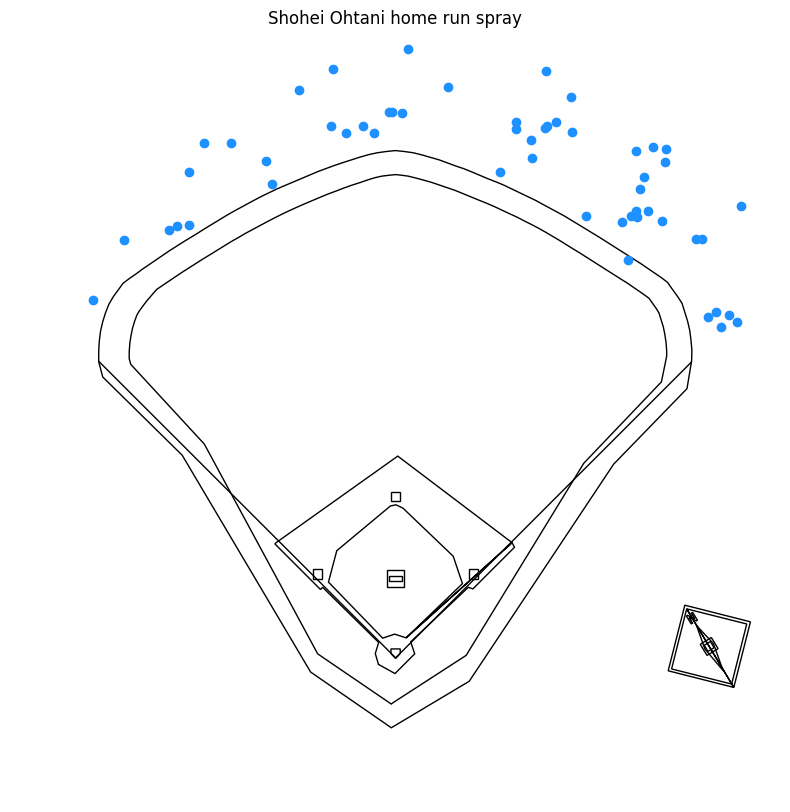

In [31]:
# Load SVG
svg_file = "../assets/svg/dodger_stadium.svg"
paths, attributes, svg_attr = svg2paths2(svg_file)

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))


# Function to extract vertices from path segments
def extract_vertices(path):
    vertices = []
    for segment in path:
        if hasattr(segment, "start"):
            vertices.append((segment.start.real, segment.start.imag))
        if hasattr(segment, "end"):
            vertices.append((segment.end.real, segment.end.imag))
    return vertices


# Plot SVG paths
for path in paths:
    vertices = extract_vertices(path)
    if vertices:
        patch = Polygon(vertices, closed=True, edgecolor="black", facecolor="none")
        ax.add_patch(patch)

# Set the aspect of the plot to be equal
ax.set_aspect("equal")


# Define conversion factors if needed, assuming 0 to 250 for SVG dimensions
def convert_coords(x, y):
    x_conv = (x / 250.0) * 250
    y_conv = (y / 250.0) * 250
    return x_conv, y_conv


# Define a color map for different event types
color_map = {
    "home_run": "#1e90ff",
    "single": "blue",
    "double": "green",
    "triple": "orange",
}

# Plot data points with different colors based on events
for index, row in df.iterrows():
    x, y = convert_coords(row["hc_x"], row["hc_y"])
    color = color_map.get(
        row["events"], "black"
    )  # Default to black if event type is not in the map
    ax.plot(x, y, "o", color=color)  # Colored dot for event location

# Set limits and title
ax.set_xlim(0, 250)
ax.set_ylim(250, 0)  # Invert the y-axis to flip the plot
ax.set_title("Shohei Ohtani home run spray")

# Hide axes
ax.axis("off")

# Show plot
plt.show()